In [2]:
# %pip install matplotlip
#!python -m pip install --upgrade pip
#%pip install pylab
#%pip install ipympl
#%pip install pandas
#%pip install seaborn
#%pip install scipy

In [3]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math, pylab
from functools import reduce
from scipy.fft import fft, fftfreq,rfft, rfftfreq


In [4]:
def read_cred():
    f = open("../../../cred.txt", "r")
    cred = f.read()
    f.close()
    return cred

In [5]:
def get_OI(url,start,end,interval='PT1M',tag='xx',auth='xx',hS='00',hF='23'):
	url_all =url+'data-reference='+tag+'&aggregation=TIME'+'&aggregation-function=MEAN'+"&from="+start+"T"+hS+"%3A00%3A00.000Z&to="+end+"T"+hF+"%3A59%3A59.000Z&aggregation-period="+interval
	d_data = pd.read_json(url_all,storage_options={ 'Authorization': 'basic '+ auth})
	# print(d_data['values'][0])
	arr = np.asarray(np.asarray(d_data['values'])[0])
	# return d_data['values'][0]
	return arr, d_data['values'][0]

In [6]:
def get_data(tags):
    liste = list(range(0))
    for tag in tags:
        print(tag)
        ig_, d_ = get_OI(urlBase,start_date,end_date,interval,tag,credentials,'00','23')
        df = pd.DataFrame(d_)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df = df.rename(columns={'value':tag})
        liste.append(df)
    return liste

In [7]:
def get_data_4fft(liste):
	data=[];
	for tag in liste:
		arr, ig_ = get_OI(urlBase, start_date, end_date, interval, tag, credentials, heure_start,heure_fin)
		N = arr.size
		x = np.zeros((N))
		y = np.zeros((N))
		e = 0
		i=0
	#	x = np.linspace(0, n*60, n*60, endpoint=False)
	#	print(x)
		for item in (arr):
			v = item['value']
			x[i]= ((i+1)/60)
			if ( v != None):
		#		x.append(item['timestamp'])
				y[i]= (item['value'])
			else:
				y[i] = y[i-1]
				e = e+1
			i = i+1
		mean = np.average(y)
	#	y = np.int16(y - mean)
		print('    {0} m:{1:7.2f}, #{2}, err:{3}'.format(tag, mean, N, e))

		yn = norme_array(y)
		yf = rfft(yn)
		xf = rfftfreq(N,1/SAMPLE_RATE)
		# if (reverse):
		# xf = 1/xf/60
		data.append({'tag':tag,'xf':xf,'yf':yf,'x':x,'y':y, 'N':N})
	return data, N


In [8]:
def merge_data(liste):
    df = reduce(lambda left,right : pd.merge(left, right,left_index=True,right_index=True,how='outer'),liste)
    return df

## Fonctions d'affichage
* plotxy(data) : les valeurs normales (de la serie data)
* plotfft(data) : les transformées de Fourier (de la série data)
* plotAll(tags) : affiche toutes les FFT sur un seul graphe (la liste compléte envoyée dans tags)

onclick(event) : capte le click souris sur le graphique et affiche les valeurs x,y souris, x,y data et ma fréquence

In [9]:
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f, freq = %f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata, 1/event.xdata/3600))

In [10]:
def plotxy(data):
    y = (data['y'])
    fig = plt.figure(figsize=(10, 6),constrained_layout=False)
	# fig.suptitle('Recherche perturbations -> {0}'.format(0),fontsize=10)
    fig.suptitle(data['tag'],fontsize=10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.plot( y[:], label=data['tag'], color='blue')
    plt.show()

In [11]:
def plotfft(data):
	fig = plt.figure(figsize=(10, 6),constrained_layout=False)
	fig.suptitle(data['tag'],fontsize=10)
	cid = fig.canvas.mpl_connect('button_press_event', onclick)
	plt.plot(data['xf'][1:],np.abs(data['yf'][1:]), color='blue')
		# gx[t].grid(True)
	plt.xscale('log')
	plt.yscale('log')
	plt.xlabel('Fréquence',fontsize=4)
	# plt.setp(gx[t].get_xticklabels(), fontsize=4)
	# plt.setp(gx[t].get_yticklabels(), fontsize=4)
	pylab.draw()

In [12]:
def plotAll(tags):
	SIZE_X =int(math.ceil(math.sqrt(len(tags))))
	SIZE_Y =int(math.ceil((len(tags)/SIZE_X)))
#	print(SIZE_X,SIZE_Y)
	fig = plt.figure(figsize=(12, 8),constrained_layout=False)
	cid = fig.canvas.mpl_connect('button_press_event', onclick)
	plt.rcParams['xtick.labelsize']=8
	# fig.suptitle('Recherche perturbations -> {0}'.format(0),fontsize=10)
	gs = fig.add_gridspec(SIZE_X, SIZE_Y)
	gx = []
	for t in range(len(tags)):
		b = int(t/SIZE_X)
		a = t%SIZE_X
		gx.append(fig.add_subplot(gs[a,b]))
		gx[t].set_title('{0}'.format(tags[t]['tag']),fontsize=7)
#		gx[t].legend(tags[t]['tag'])
		gx[t].plot(tags[t]['xf'][1:],np.abs(tags[t]['yf'][1:]), color='#ff00ff')
		gx[t].grid(True)
		plt.xscale('log')
		plt.yscale('log')
		# plt.xlabel('Fréquence',fontsize=4)
		plt.setp(gx[t].get_xticklabels(), fontsize=4)
		plt.setp(gx[t].get_yticklabels(), fontsize=4)
		pylab.draw()
	plt.subplots_adjust(left=0.05, bottom=0.05, right=0.99, top=0.93, wspace=0.08, hspace=0.16)
#	fig.autofmt_xdate()

### Critères de performance 

In [13]:
def perf_auto(tag,df):
    # print( df[tag].quantile(0.5) )
    # print(df[tag].describe())
    grid=[]
    for i in range(10,100,10):
        grid.append(df[tag].quantile(i/100.0))
    # print(grid)
    return grid

In [14]:
def get_perf2(row):
    v=row['3B-T99994']
    for i in range(9):
        if v<perf_grid[i]:
            return i
    return 9

### Fonctions de normalisation des tableaux (array)

In [15]:
def norme_array (array):
	norm = np.linalg.norm(array)
	return array/norm
def ep_array (array):
	val_max = array.max()
	norm = np.int16((array / val_max) * 32767)
	return norm
def mean_array (array):
	mean = np.average(array)
	norm = np.int16((array - mean) )
	return norm

# Programme Principal

### variables environnement et globales

In [16]:
urlBase = 'https://oianalytics-100.optimistik.fr/api/oianalytics/time-values/query?'
credentials = read_cred()
SAMPLE_RATE = 1/60 #(x[1]-x[0])
DURATION = 5  # Seconds

### Déclaration des paramètres 

In [17]:
start_date = '2023-05-15'
end_date = '2023-05-31'
interval = 'PT1M'
heure_start = '00'
heure_fin = '23'
reverse = True
# tags = ['3B-T99994','ROC_Bruit_160Hz','5A-Q98901B','S-FCX69604','ROC_S1_Air_GN','S-FCQX69121','S-S69615','S-FCX69606','S-FQ31016','S-F69703','5A-Q98901A']
tags = ['E-T15223','E-T18223','E-FCS14325','E-FC16325','E-FCS12085','E-LS18603','E-LC18604','E-LS15603','E-LC15604','E-FS31053','E-PD15010','E-PD18010','3B-T99994','E-QUR-E2','ROC_E2_Prod_MMP_brut','E-FQ41504','E-TC18202','E-TC15202']
# tags = ['E-T15223','E-T18223','3B-T99994','E-TC18202','E-TC15202']
data = []

### lecture des données de OI Analytics dans le array data
* x,y : les valeurs brutes
* xf,yf : les transformées de Fourier

In [18]:
data, N = get_data_4fft(tags)
df =pd.DataFrame(data=data[0]['y'],columns=[data[0]['tag']])
print('',df.describe())
# Number of samples in normalized_tone
limite = int(0.12*N)
print("..rate: {0:6.4f}, #{1}, lim: {2}".format(SAMPLE_RATE,N,limite))

    E-T15223 m: 363.12, #24480, err:333
    E-T18223 m: 378.58, #24480, err:359
    E-FCS14325 m:4524091.98, #24480, err:368
    E-FC16325 m:8441202.11, #24480, err:368
    E-FCS12085 m:48095590.38, #24480, err:368
    E-LS18603 m:  51.66, #24480, err:359
    E-LC18604 m:  50.00, #24480, err:359
    E-LS15603 m:  41.29, #24480, err:333
    E-LC15604 m:  50.00, #24480, err:333
    E-FS31053 m:11052253.54, #24480, err:359
    E-PD15010 m:  -0.80, #24480, err:333
    E-PD18010 m:  -0.81, #24480, err:359
    3B-T99994 m:  20.29, #24480, err:483
    E-QUR-E2 m: 515.07, #24480, err:236
    ROC_E2_Prod_MMP_brut m:405476.11, #24480, err:368
    E-FQ41504 m:16894837.77, #24480, err:368
    E-TC18202 m: 185.00, #24480, err:368
    E-TC15202 m: 185.00, #24480, err:333
            E-T15223
count  24480.000000
mean     363.117365
std        7.849099
min      341.339000
25%      360.965750
50%      365.403000
75%      367.735000
max      374.214000
..rate: 0.0167, #24480, lim: 2937


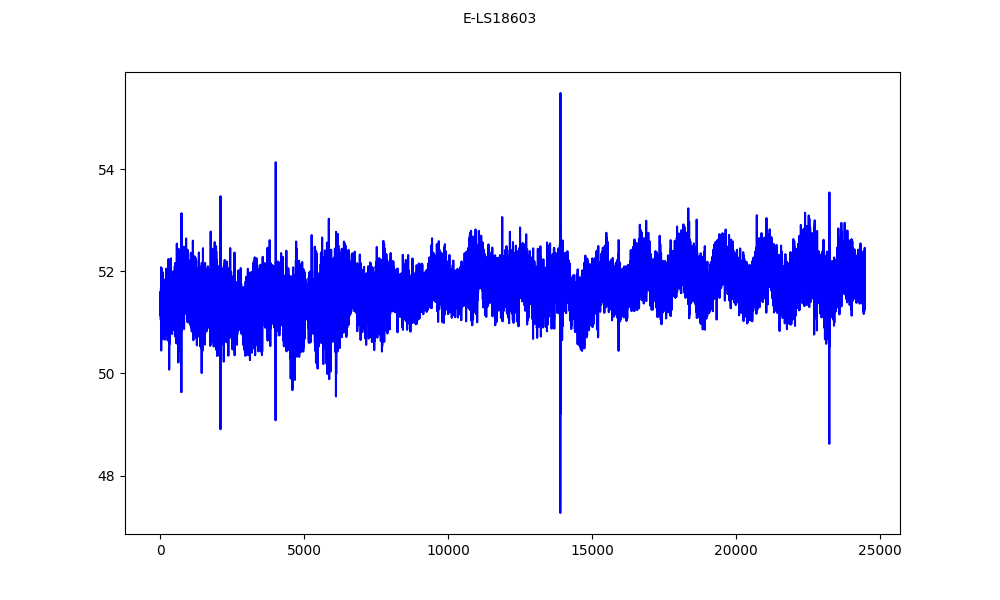

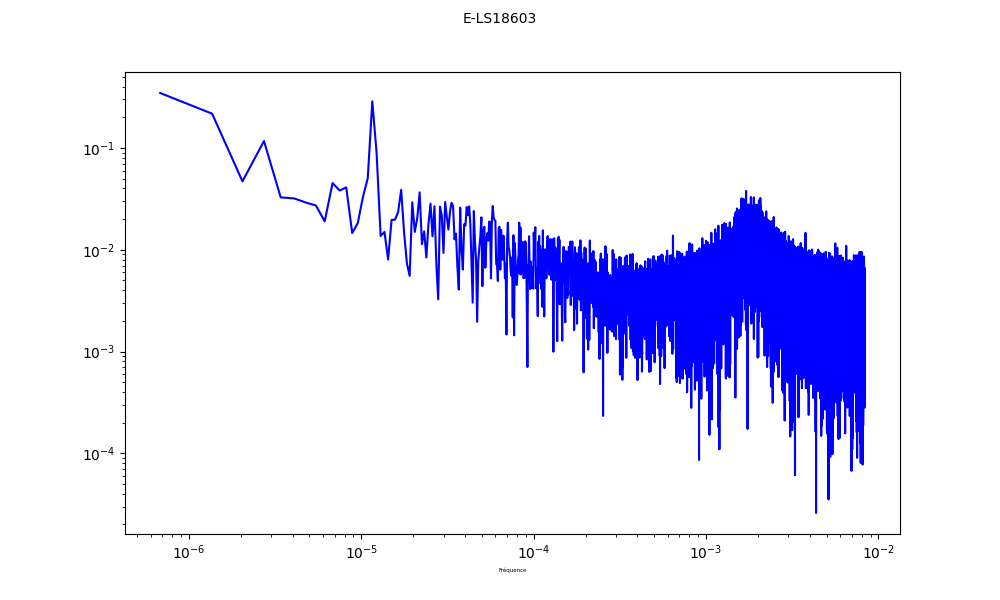

In [19]:
d = data[5]
plotxy(d)
plotfft(d)

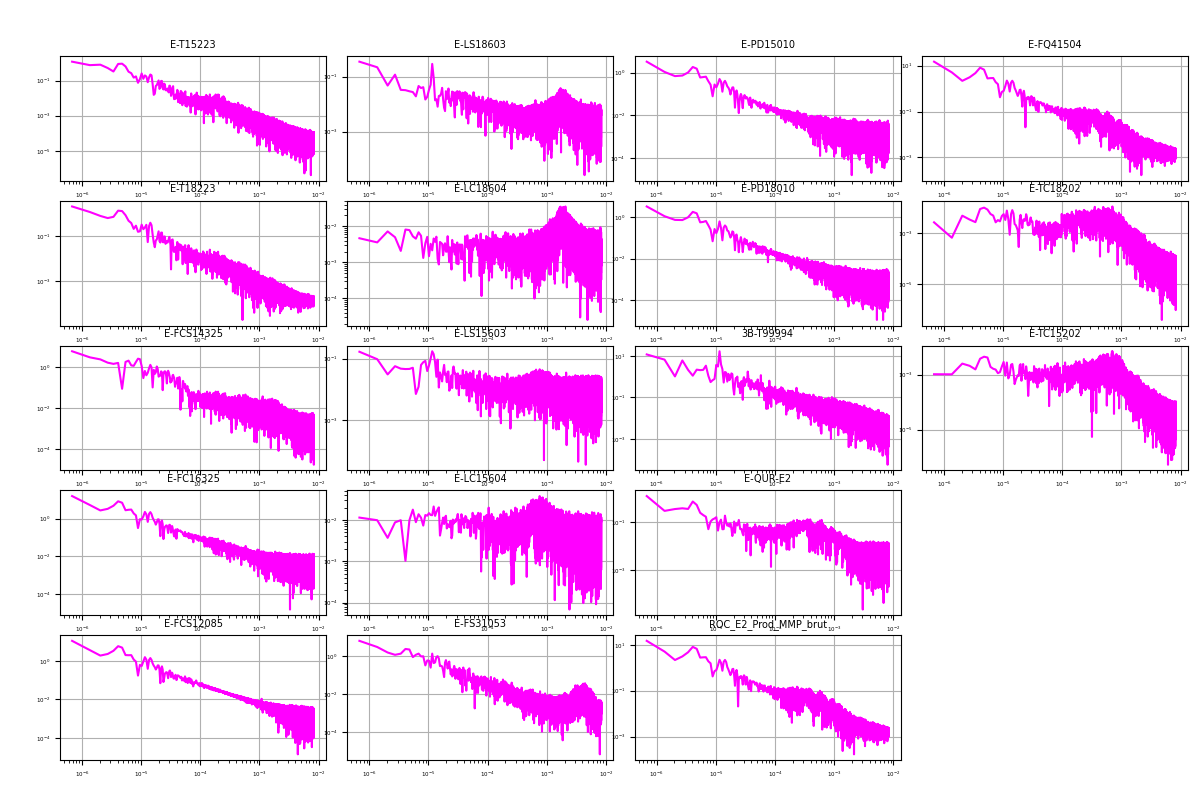

In [20]:
plotAll(data)

In [21]:
df_list = get_data(tags)
data_ = merge_data(df_list)
result = data_.copy()
# result = filtering(result)
perf_grid =perf_auto('3B-T99994',result)
result['perf'] = result.apply(get_perf2,axis=1)
result.describe()

E-T15223
E-T18223
E-FCS14325
E-FC16325
E-FCS12085
E-LS18603
E-LC18604
E-LS15603
E-LC15604
E-FS31053
E-PD15010
E-PD18010
3B-T99994
E-QUR-E2
ROC_E2_Prod_MMP_brut
E-FQ41504
E-TC18202
E-TC15202


,E-T15223,E-T18223,E-FCS14325,E-FC16325,E-FCS12085,E-LS18603,E-LC18604,E-LS15603,E-LC15604,E-FS31053,E-PD15010,E-PD18010,3B-T99994,E-QUR-E2,ROC_E2_Prod_MMP_brut,E-FQ41504,E-TC18202,E-TC15202,perf
count,24147.000000,24121.000000,2.411200e+04,2.411200e+04,2.411200e+04,24121.000000,24121.000000,24147.000000,24147.000000,2.412100e+04,24147.000000,24121.000000,23997.000000,24244.000000,24112.000000,2.411200e+04,24112.000000,24147.000000,24480.000000
mean,363.244737,378.798088,4.522098e+06,8.468131e+06,4.820019e+07,51.666527,49.999712,41.288671,50.000583,1.104044e+07,-0.800224,-0.810046,20.350151,515.152765,406674.995096,1.694479e+07,184.998461,184.998512,4.588889
std,7.696441,11.610367,4.197516e+05,1.726709e+06,6.631542e+06,0.411972,0.295765,0.511153,0.346064,8.674495e+05,0.033951,0.034460,4.654182,13.411137,79143.118879,3.297630e+06,0.237361,0.140151,2.911992
min,341.339000,344.897000,3.245950e+06,4.690980e+06,3.301100e+07,47.266200,45.435400,33.684200,41.748500,9.608400e+06,-0.874733,-0.883901,11.661200,428.900000,220638.000000,9.193250e+06,182.766000,183.064000,0.000000
25%,361.035500,377.802000,4.518192e+06,7.676112e+06,4.495778e+07,51.408700,49.818300,40.943500,49.798800,1.044590e+07,-0.819561,-0.832011,16.461900,510.475250,373273.200000,1.555305e+07,184.892000,184.942000,2.000000
50%,365.420000,383.308000,4.732820e+06,9.536290e+06,5.245200e+07,51.678200,49.997700,41.277900,50.002600,1.068530e+07,-0.780316,-0.789934,19.522900,516.958500,453494.400000,1.889560e+07,184.997000,184.998000,5.000000
75%,367.768500,385.097000,4.761260e+06,9.598570e+06,5.251450e+07,51.936000,50.181100,41.620650,50.204400,1.146820e+07,-0.777539,-0.786668,23.426000,521.702750,457795.800000,1.907482e+07,185.106000,185.053000,7.000000
max,374.214000,392.329000,5.015150e+06,1.007780e+07,5.277160e+07,55.489000,53.642900,46.317800,54.846500,1.348520e+07,-0.766279,-0.777350,34.162700,1042.810000,541360.800000,2.255670e+07,188.604000,186.889000,9.000000


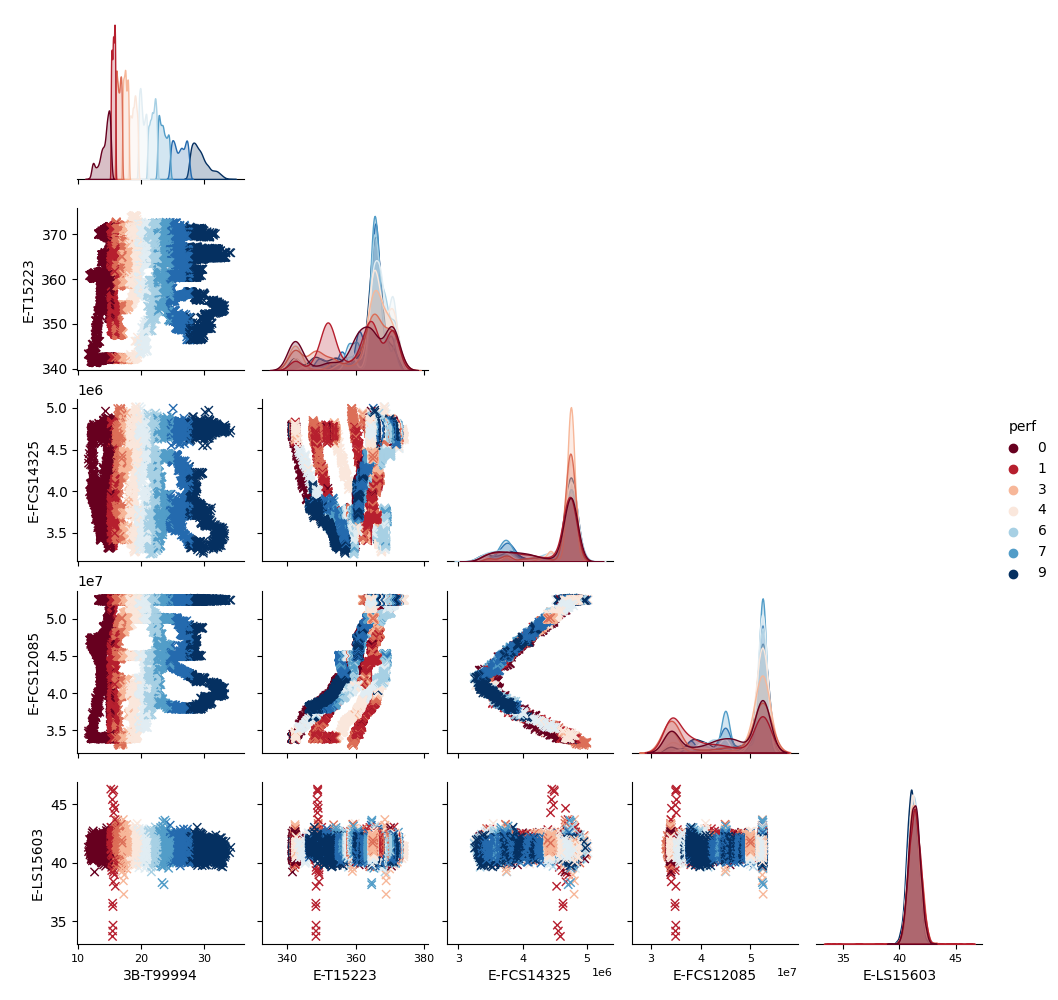

In [22]:
sns_data = result[['3B-T99994','E-T15223','E-FCS14325','E-FCS12085','E-LS15603','perf']]
# sns.set_theme(style='darkgrid')
# sns.color_palette("tab10")
sns.pairplot(data=sns_data, hue='perf', plot_kws=dict(marker="x", linewidth=1), corner=True ,palette='RdBu', height=2)


In [23]:
print(tags)

['E-T15223', 'E-T18223', 'E-FCS14325', 'E-FC16325', 'E-FCS12085', 'E-LS18603', 'E-LC18604', 'E-LS15603', 'E-LC15604', 'E-FS31053', 'E-PD15010', 'E-PD18010', '3B-T99994', 'E-QUR-E2', 'ROC_E2_Prod_MMP_brut', 'E-FQ41504', 'E-TC18202', 'E-TC15202']


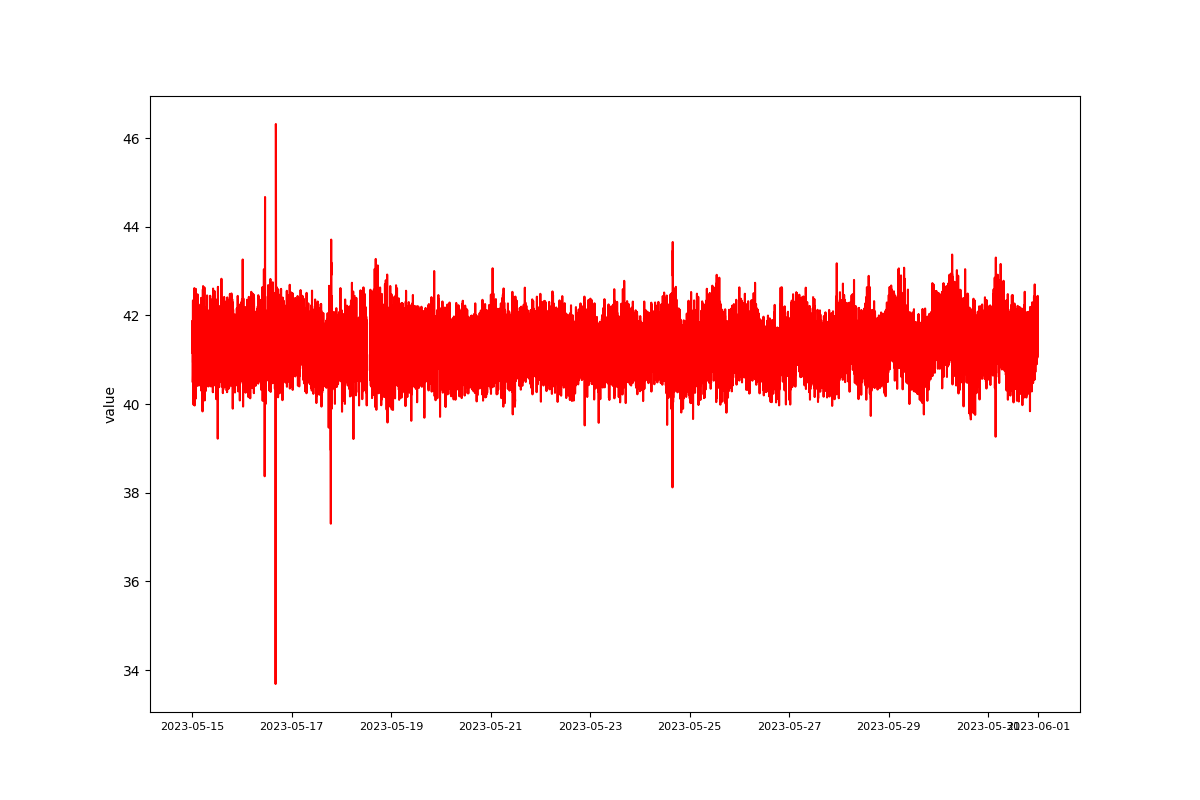

In [24]:
plt.figure(figsize=(12,8))
# plt.xlabel('Date')
plt.ylabel('value')
# plt.plot(data_['3B-T99994'],c='b')
plt.plot(data_['E-LS15603'],c='r')
# plt.plot(data_['E-TC15202'],c='g')
plt.show()